In [2]:
using Pkg
Pkg.activate("/media/mat/HDD/EnKF/")

"/media/mat/HDD/EnKF/Project.toml"

In [3]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using Plots
using ProgressMeter
using DifferentialEquations

We are interested in simulating the Lorenz attractor
            $$ ẋ = \sigma(y - x)\\
       ẏ = x(\rho-z) - y\\
       ż = xy - \beta z$$

Define parameters of the Lorenz attractor

In [71]:
function lorenz(du,u,p,t)
 du[1] = 10.0*(u[2]-u[1])
 du[2] = u[1]*(28.0-u[3]) - u[2]
 du[3] = u[1]*u[2] - (8/3)*u[3]
end

# u0 = [1.508870; -1.531271; 25.46091]
u0 = [1.0; 0.0; 0.0]
tspan = (0.0,40.0)
prob = ODEProblem(lorenz,u0,tspan)
sol = solve(prob)

Δt = 1e-2
T = tspan[1]:Δt:tspan[end]
integrator = init(prob, RK4(), adaptive =false, dt = Δt, save_everystep=false)

t: 0.0
u: 3-element Array{Float64,1}:
 1.0
 0.0
 0.0

In [72]:
states = [deepcopy(u0)]

1-element Array{Array{Float64,1},1}:
 [1.0, 0.0, 0.0]

In [73]:
for t in T[1:end-1]
    step!(integrator)
    push!(states, deepcopy(integrator.u))
end

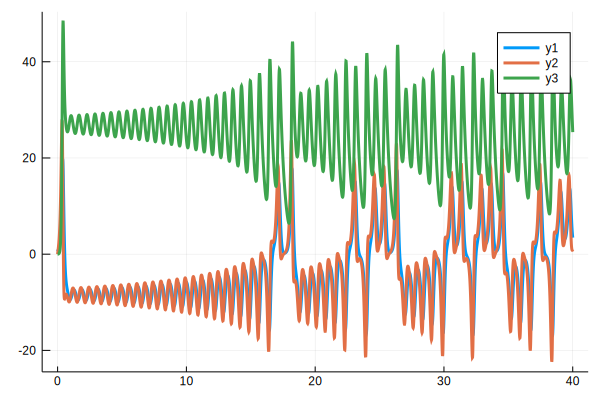

In [74]:
plot(T, hcat(states...)[1,:], linewidth  = 3)
plot!(T, hcat(states...)[2,:], linewidth = 3)
plot!(T, hcat(states...)[3,:], linewidth = 3)

Define propagation function fprop

In [75]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
        for j=1:10
        step!(integrator)
        end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [76]:
integrator

t: 40.0
u: 3-element Array{Float64,1}:
  3.43550126384442 
  0.975068640837666
 25.375884978423244

In [77]:
step!(integrator)

In [78]:
fprop = PropagationFunction()

PropagationFunction()

Define measurement function m

In [79]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    return s
end

In [80]:
function (::MeasurementFunction)(t::Float64)
    return I
end

In [81]:
m = MeasurementFunction()

MeasurementFunction()

Define  real measurement function z

In [82]:
Z = AdditiveInflation(MvNormal(zeros(3), 1e-3*I))

AdditiveInflation{3}(IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6]
)
)

In [83]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    return Z(ENS)
end

In [84]:
z = RealMeasurementFunction()

RealMeasurementFunction()

Define covariance inflation

In [85]:
A = MultiAdditiveInflation(3, 1.01, MvNormal(zeros(3), 1.0*I))

MultiAdditiveInflation{3}(1.01, IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)
)

Define noise covariance

In [86]:
ϵ = AdditiveInflation(MvNormal(zeros(3), 1e-3*I))

AdditiveInflation{3}(IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6]
)
)

In [97]:
N = 20
NZ = 3
isinflated = true
isfiltered = false
isaugmented = false

false

In [98]:
ens = initialize(N, MvNormal(u0, 2.0*I))
estimation_state = [deepcopy(ens.S)]

tmp = deepcopy(u0)
true_state = [deepcopy(u0)]

1-element Array{Array{Float64,1},1}:
 [1.0, 0.0, 0.0]

In [99]:
ens

EnsembleState{20,Array{Float64,1}}(Array{Float64,1}[[3.10645, -3.23096, 3.07975], [1.21569, -1.99516, 1.96051], [3.11906, -3.04935, -0.828921], [1.56811, -3.00297, -2.1999], [5.83109, -3.17325, -0.948694], [-1.74781, -1.5615, -0.391205], [1.79825, 2.11374, 1.99609], [-0.388946, 0.433391, -2.62906], [3.33707, 0.238818, 2.60352], [-3.35275, -1.47852, 0.0200715], [-1.45308, -0.65827, 1.7066], [4.79714, 3.93785, -2.87194], [-1.64154, 0.65292, 4.1583], [1.01919, -0.631672, 0.875802], [3.91859, -1.39336, -3.42992], [2.56085, 0.950914, 0.179249], [1.63012, -0.120193, -1.49519], [2.35507, 2.16235, 3.31345], [3.13378, 0.225823, -1.19932], [-1.73531, 1.65572, 2.76735]])

In [100]:
g = FilteringFunction()

FilteringFunction()

In [101]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{20,3}(PropagationFunction(), MultiAdditiveInflation{3}(1.01, IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)
), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{3}(IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6]
)
), true, false, false)

### Ensemble Kalman filter estimation

In [102]:
Δt = 1e-2
T = 0.0:10*Δt:40.0

@showprogress for (n,t) in enumerate(T)
    
#     push!(true_state, deepcopy(tmp))
    
    
    
    global ens
#     enkf.f(t, ens)
    t, ens = enkf(t, 10*Δt, ens)
    
    push!(estimation_state, deepcopy(ens.S))
    

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


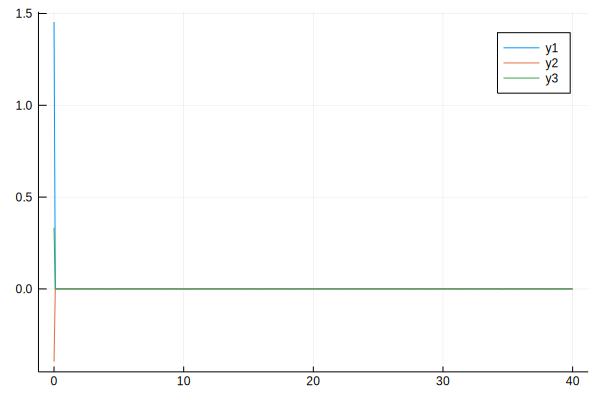

In [103]:
ŝ =  hcat(mean.(estimation_state)...)

plot(T,ŝ[1,1:end-1])
plot!(T,ŝ[2,1:end-1])
plot!(T,ŝ[3,1:end-1])


# s =  hcat(true_state...)
# plot!(sol, vars = (1))

In [ ]:
sol

In [71]:
sol.t

1287-element Array{Float64,1}:
   0.0                  
   3.5678604836301404e-5
   0.0003924646531993154
   0.0032624016752212923
   0.00905808176456279  
   0.0169564955927642   
   0.02769000245764448  
   0.04185634375662893  
   0.06024025665362463  
   0.0836852441654334   
   0.11336451506889586  
   0.14862131186030308  
   0.18703929175446188  
   ⋮                    
  99.17448947475748     
  99.25177886977121     
  99.3340481055892      
  99.40002509604705     
  99.47321520444633     
  99.54429913558833     
  99.6304176475736      
  99.73556893651245     
  99.81512588011671     
  99.88533419341042     
  99.94751447208056     
 100.0                  

In [69]:
collect(T)

1001-element Array{Float64,1}:
 0.0  
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01 
 0.011
 0.012
 ⋮    
 0.989
 0.99 
 0.991
 0.992
 0.993
 0.994
 0.995
 0.996
 0.997
 0.998
 0.999
 1.0  